# Process `DAOD_PHYSLITE` with `coffea` and `dask_awkward`

Changes with `uproot` v5 and `awkward` v2:
- Intermediate ("layout") layer of `awkward` is python now (instead of c++, largely invisible to the user)
- No more virtual arrays (used for "lazy loading" before)
- Laziness is now handled with `dask`
- Awkward dask collection available within `dask_awkward` and corresponding I/O functions like `uproot.dask`, `dask_awkward.from_parquet`, ...

Other developments in the meantime
- Awkward Forth used by default in `uproot` to read more complicated data like `vector<vector<...`
  - unfortunately often issues with this, e.g. [uproot#951](https://github.com/scikit-hep/uproot5/issues/951)
- `PHYSLITE` schema in `coffea.nanovents`
- Now also dask-capable

Let's try it out on google cloud!

In [1]:
import warnings
import copy

import awkward as ak
import dask
import uproot
import dask_awkward as dak
import uproot
import coffea.nanoevents
from coffea.nanoevents import PHYSLITESchema, NanoEventsFactory
import matplotlib.pyplot as plt

## First: some workarounds and hacks

Going to load a bit of code with `%run` - one way to make it available in dask gateway workers without much effort.

Some hacks for the PHYSLITE schema to avoid reading ElementLink branches when we don't need them

In [2]:
%run patched_physlite_schema.py

In [3]:
coffea.nanoevents.factory.PHYSLITESchema = PHYSLITESchema

For efficient reading from GCS we want to use asyncio with a large connection Pool (100 TCP connections, → see [my presentation from meeting on 2021-06-23](https://indico.cern.ch/event/1051375/contributions/4417883/subcontributions/342717/attachments/2270061/3855088/nikolai-google_meeting-http_access-23.06.2021.pdf))

This is not yet implemented in uproot, but [likely in the future uproot is going to use `fsspec` for remote I/O (both http and xrootd)](https://github.com/scikit-hep/uproot5/pull/692), so we can try this out already now with a custom fsspec uproot source:

In [4]:
%run fsspec_source.py

Now we need some stuff to use/authenticate to rucio

In [5]:
rse = "GOOGLE-EU_DATADISK"

Upload voms proxy:

In [6]:
from ipywidgets import FileUpload
upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

Utils for rucio handling:

In [7]:
%run rucio_utils.py

In [8]:
x509_data = bytes(upload.value[0]["content"])
setup_rucio_and_proxy(x509_data, rucio_account="nihartma")

We will also delay the fetching of signed urls to the uproot source such that this is only done once the file is accessed. This is similar to the [uproot S3 source](https://github.com/scikit-hep/uproot5/blob/cb70ce0715276bbc403cb48a511c8a3b27cffe7f/src/uproot/source/s3.py#L83), but we use rucio here for getting the signed urls

In [9]:
class RucioFileGCPSource(FSSpecHttpSource):
    def __init__(self, file_path, **kwargs):
        scope, name = file_path.split(".", maxsplit=1) # take filename in "{scope}.{name}" format
        url = get_signed_url(scope, name, rse=rse)
        super().__init__(url, **kwargs)

Coffea doesn't pass uproot options through in dask mode yet (but will after [coffea#887](https://github.com/CoffeaTeam/coffea/pull/887) gets merged), so we have to monkey patch this for now:

In [10]:
from functools import wraps, partial

def patch_uproot_dask(f):
    return wraps(f)(partial(f, file_handler=RucioFileGCPSource))

if hasattr(uproot.dask, "__wrapped__"):
    # unpatch if already patched
    uproot.dask = uproot.dask.__wrapped__

if not hasattr(uproot.dask, "__wrapped__"):
    # patch if not patched
    uproot.dask = patch_uproot_dask(uproot.dask)

## Now for the actual analysis

In [11]:
filename = "mc21_13p6TeV.DAOD_PHYSLITE.33080408._000001.pool.root.1" # in scope.filename format

In [12]:
factory = NanoEventsFactory.from_root(
    {filename: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    permit_dask=True
)

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    events = factory.events()

This gives us a dask array now - no data (except for metadata) has been read yet. For more info on `dask_awkard` in `coffea` see [Lindsey's presentation at CHEP23](https://indico.jlab.org/event/459/contributions/11533/attachments/9496/13762/CoffeaCHEP_LindseyGray_09052023.pdf)

Some notes on the PHYSLITE schema for `coffea.nanoevents`:
- This notebook runs with the changes introduced in [coffea#888](https://github.com/CoffeaTeam/coffea/pull/888) and [coffea#872](https://github.com/CoffeaTeam/coffea/pull/872)
- Still in an experimental stage (still a couple of issues to solve, see [coffea#540](https://github.com/CoffeaTeam/coffea/issues/540))
- We may not need to have the PHYSLITE schema forever in the `coffea` repo, at some point it may even not be necessary anymore to use `coffea` at all for this (more and more features get merged back/implemented in the other packages)

In [14]:
events

dask.awkward<from-uproot, npartitions=1>

In [15]:
events.fields

['xTrigDecision',
 'METAssoc_MET',
 'AntiKt10TruthSoftDropBeta100Zcut10Jets',
 'AntiKt4TruthDressedWZJets',
 'BunchConfKey',
 'TrigConfKeys',
 'TrigConfKeysOnline',
 'index_ref',
 'Electrons',
 'Jets',
 'Muons',
 'Photons',
 'TauJets',
 'BTagging_AntiKt4EMPFlow',
 'BornLeptons',
 'CombinedMuonTrackParticles',
 'EventInfo',
 'ExtrapolatedMuonTrackParticles',
 'GSFConversionVertices',
 'GSFTrackParticles',
 'HLTNav_RepackedFeatures_Particle',
 'HLTNav_Summary_DAODSlimmed',
 'HardScatterParticles',
 'HardScatterVertices',
 'InDetTrackParticles',
 'Kt4EMPFlowEventShape',
 'MET_Core_MET',
 'MET_Truth',
 'MuonSpectrometerTrackParticles',
 'PrimaryVertices',
 'TauTracks',
 'TruthBoson',
 'TruthBosonsWithDecayParticles',
 'TruthBosonsWithDecayVertices',
 'TruthBottom',
 'TruthElectrons',
 'TruthEvents',
 'TruthMuons',
 'TruthNeutrinos',
 'TruthPhotons',
 'TruthPrimaryVertices',
 'TruthTop',
 'egammaClusters',
 'LargeRJets',
 'TruthTaus',
 'HLTNav_RepackedFeatures_MET',
 'TruthForwardProtons']

To actually read something we have to call `.compute()`

In [16]:
events.Electrons.pt.compute()

<Array [[5.92e+03], [], ..., [], []] type='20000 * var * float32[parameters...'>

`dask_awkward` can figure out which columns to load, e.g. for calculating `px` we need `pt` and `phi`:

In [39]:
dak.necessary_columns(events.Electrons.px)

{'from-uproot-222bceb9ec616657822c40fcd6ecc558': ['Electrons.pt',
  'Electrons.phi']}

In principle ElementLinks also work:

In [42]:
events.Electrons.trackParticles.pt.compute()

<Array [[[4.59e+03]], [], [[...]], ..., [], []] type='20000 * var * var * ?...'>

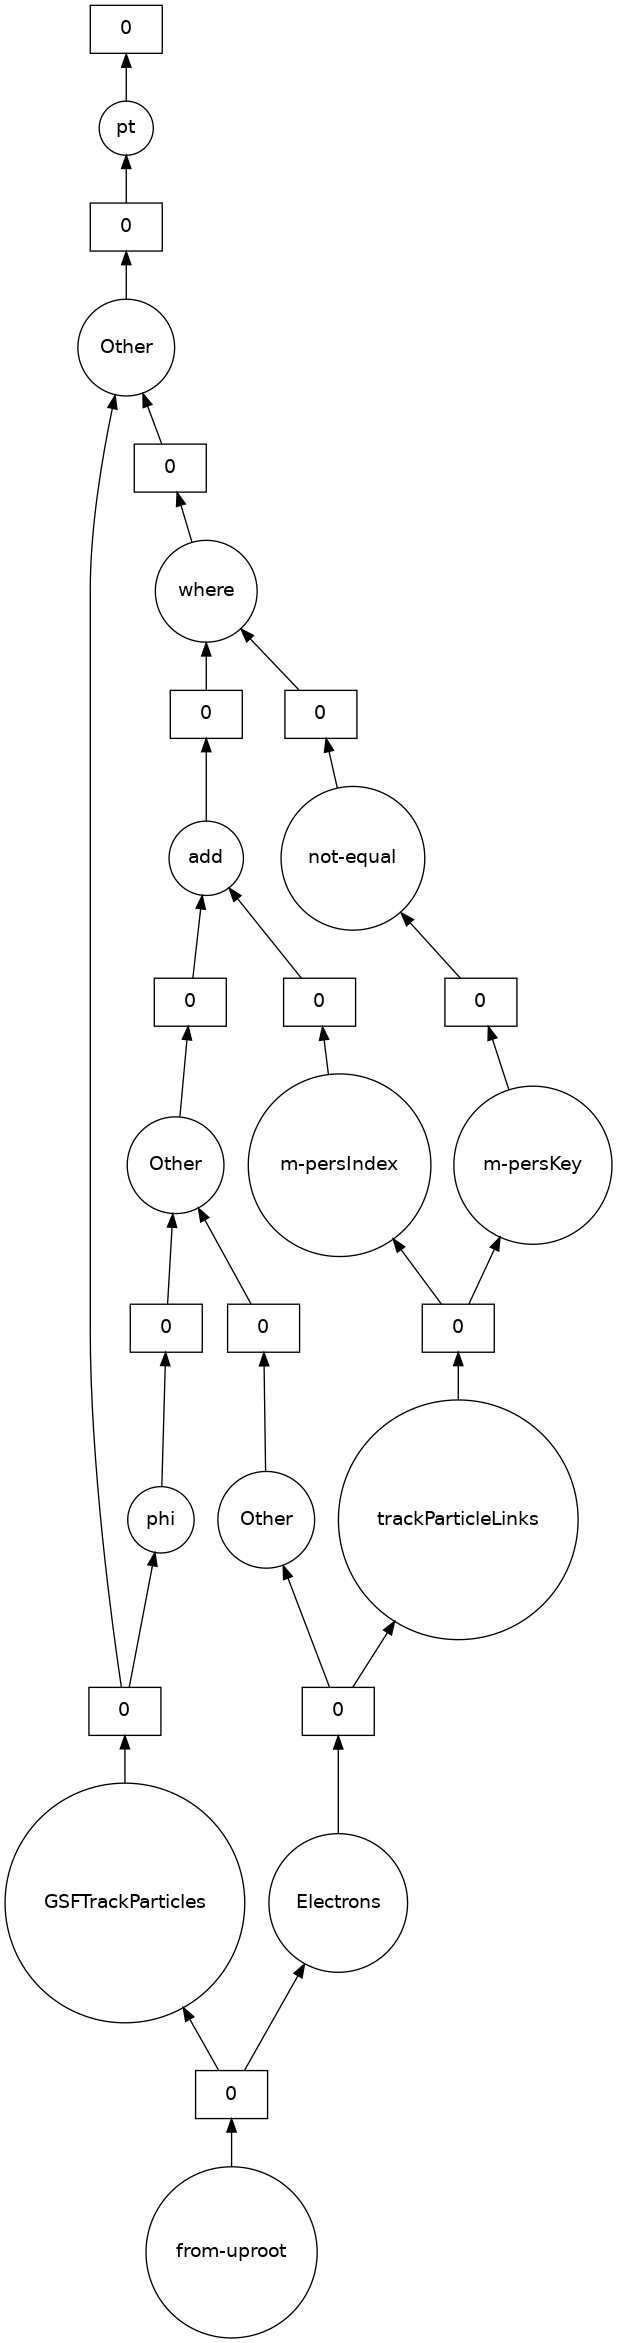

In [43]:
events.Electrons.trackParticles.pt.visualize()

In [44]:
dak.necessary_columns(events.Electrons.trackParticles.pt)

{'from-uproot-222bceb9ec616657822c40fcd6ecc558': ['Electrons.trackParticleLinks.m_persKey',
  'GSFTrackParticles.qOverP',
  'GSFTrackParticles.phi',
  'Electrons._eventindex',
  'GSFTrackParticles.theta',
  'Electrons.trackParticleLinks.m_persIndex']}

### Simple ttbar analysis

Currently however some issues with reading some of the branches ([uproot#951](https://github.com/scikit-hep/uproot5/issues/951)) so this doesn't work reliably yet.

Therefore we run an example here that does not need any Elementlinks

Inspired by the [Analysis Grand Challenge (AGC)](https://agc.readthedocs.io/en/latest/) we attempt to reconstruct a hadronically decaying top quark for semi-leptonic ttbar events. Copying their graphic here:

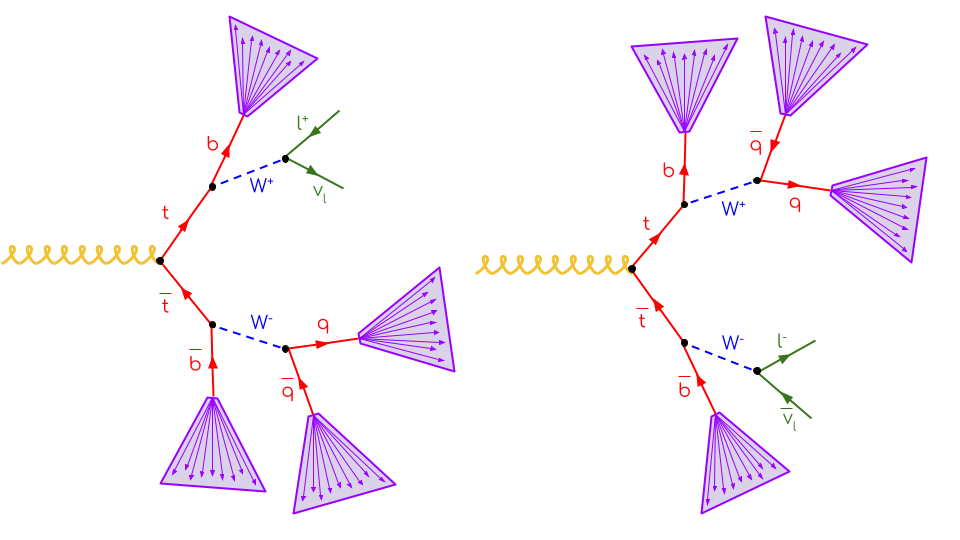


### Event and object selection
First, we do an event selection and decorate the Jets with btagging info:

- at least 4 Jets (1 from the leptonic decay, 3 from the hadronic one)
- exactly one (reasonably high transverse momentum and central) Electron or Muon
- choose btagging with 85% working point
- at least 2 bjets

In [51]:
GeV = 1000.

In [52]:
# TODO: replace by more realistic selections
def electron_selection(el):
    return (el.pt > 30 * GeV) & (abs(el.eta) < 2.47)

def muon_selection(mu):
    return (mu.pt > 30 * GeV) & (abs(mu.eta) < 2.47)

def jet_selection(j):
    return (j.pt > 30 * GeV) & (abs(j.eta) < 2.47)

In [53]:
def selection(events):
    #events = copy.copy(events) # make shallow copy - needs https://github.com/dask-contrib/dask-awkward/pull/324
    events = ak.with_field(events, events.Jets, "Jets") # workaround

    # TODO: overlap removal

    # decorations
    events["Jets", "btagging"] = events.BTagging_AntiKt4EMPFlow # technically this is an ElementLink, but seems in PHYSLITE exactcly one link for each jet
    events["Jets", "is_bjet"] = events.Jets.btagging.DL1dv01_pb > 0.85 # is this how to select 85% working point?

    # object selection
    events["Electrons"] = events.Electrons[electron_selection(events.Electrons)]
    events["Muons"] = events.Muons[muon_selection(events.Muons)]
    events["Jets"] = events.Jets[jet_selection(events.Jets)]

    # event selection
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly 1 Lepton
        & (ak.sum(events.Jets.is_bjet, axis=1) >= 2) # at least 2 bjets
    ]
    return events

In [54]:
events.Electrons.pt

dask.awkward<pt, npartitions=1>

In [55]:
ev_sel = selection(events)

Note: Now we need all columns used in the selection to calculate everything:

In [56]:
dak.necessary_columns(ev_sel.Jets.is_bjet)

{'from-uproot-222bceb9ec616657822c40fcd6ecc558': ['Muons.eta',
  'Electrons.pt',
  'Electrons.eta',
  'Muons.pt',
  'Jets.eta',
  'BTagging_AntiKt4EMPFlow.DL1dv01_pb',
  'Jets.pt']}

### Top quark reconstruction

- Form all combinations of 3 jets
- Require at least one bjet in the combination
- Choose the candidate with largest transverse momentum

In [58]:
def mjjj(jets):
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    has_b = (j1.is_bjet + j2.is_bjet + j3.is_bjet) > 0
    candidates["p4"] = j1 + j2 + j3
    candidates = candidates[has_b]
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return ak.flatten(candidates.p4.mass, axis=None)

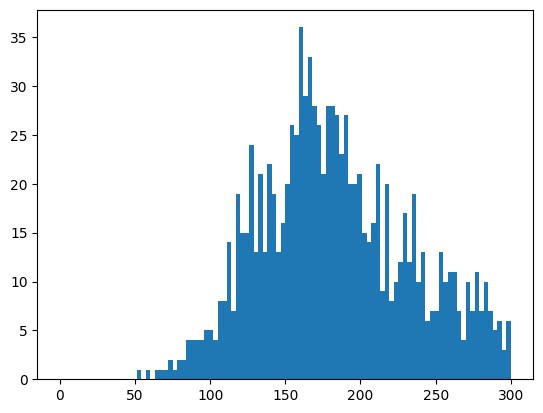

In [59]:
plt.hist(mjjj(ev_sel.Jets).compute().to_numpy() / GeV, bins=100, range=(0, 300));

We can see a peak, roughly at the top quark mass (used a file with simulated top quark pair events)

The whole task graph:

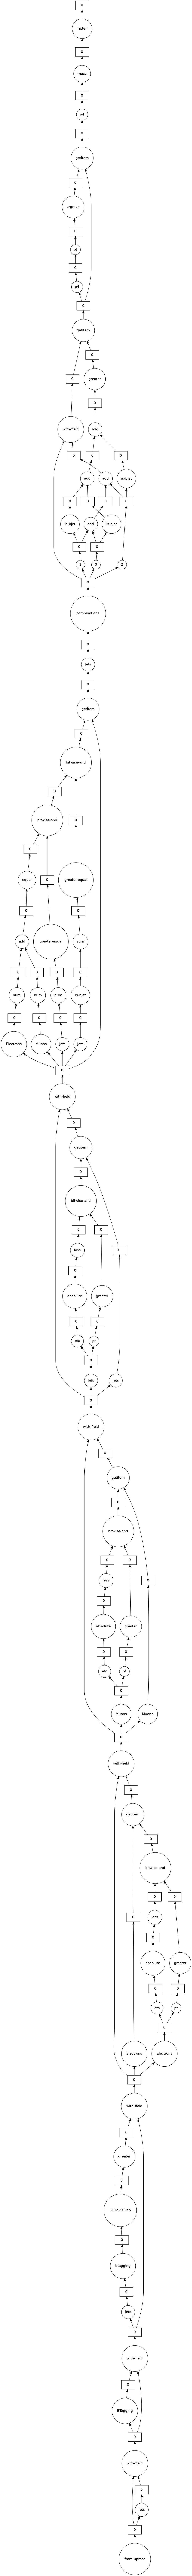

In [60]:
mjjj(ev_sel.Jets).visualize()

However this gets optimized to a single operation (no communication nescessary, can apply this independently on each file/partition)

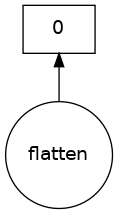

In [61]:
mjjj(ev_sel.Jets).visualize(optimize_graph=True)

# Apply this to a distributed `dask_awkward` array

Now start a cluster with [manage_cluster.ipynb](manage_cluster.ipynb) and connect to it

In [62]:
from dask_gateway import Gateway
gateway = Gateway()

In [77]:
clusters = gateway.list_clusters()
clusters

[ClusterReport<name=default.47e41eb0cfea4cbe8881c7da8c9a3abd, status=RUNNING>]

In [78]:
cluster = gateway.connect(clusters[0].name)

In [79]:
client = cluster.get_client()

In [107]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/default.47e41eb0cfea4cbe8881c7da8c9a3abd/status,


Register the rucio setup plugin that copies the voms proxy and sets the env variables on all workers:

In [115]:
client.register_worker_plugin(SetupRucioAndProxyWorker(x509_path="x509", rucio_account="nihartma"))

{'tls://10.64.2.2:39971': {'status': 'OK'},
 'tls://10.64.2.3:45117': {'status': 'OK'},
 'tls://10.64.2.4:35019': {'status': 'OK'},
 'tls://10.64.2.5:37167': {'status': 'OK'},
 'tls://10.64.2.6:44789': {'status': 'OK'},
 'tls://10.64.2.7:37149': {'status': 'OK'},
 'tls://10.64.2.8:36885': {'status': 'OK'},
 'tls://10.64.3.2:45155': {'status': 'OK'},
 'tls://10.64.3.3:37961': {'status': 'OK'},
 'tls://10.64.4.2:37175': {'status': 'OK'},
 'tls://10.64.4.3:38563': {'status': 'OK'},
 'tls://10.64.4.4:34627': {'status': 'OK'},
 'tls://10.64.4.5:43385': {'status': 'OK'},
 'tls://10.64.4.6:38737': {'status': 'OK'},
 'tls://10.64.4.7:37943': {'status': 'OK'},
 'tls://10.64.4.8:37889': {'status': 'OK'}}

List all files for the ttbar sample:

In [116]:
import rucio.client
rucio_client = rucio.client.Client(ca_cert="cern_bundle.pem")

In [117]:
files = list(
    rucio_client.list_files(
        "mc21_13p6TeV", "mc21_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8453_s3873_r13829_p5631"
    )
)

In [118]:
files[0]

{'scope': 'mc21_13p6TeV',
 'name': 'DAOD_PHYSLITE.33080408._000001.pool.root.1',
 'bytes': 332389289,
 'adler32': '1165dc9c',
 'guid': 'FED4AB7C699ABB479E236074128FA917',
 'events': 20000}

In [119]:
len(files)

538

In [120]:
def get_events(files):
    factory = NanoEventsFactory.from_root(
        {f"{file['scope']}.{file['name']}": "CollectionTree" for file in files},
        schemaclass=PHYSLITESchema,
        permit_dask=True,
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        events = factory.events()
    
    return events

In [127]:
events = get_events(files)

In [128]:
events

dask.awkward<from-uproot, npartitions=538>

We still see the whole dataset as a single `dask_awkward` array, just now it has many partitions. We can apply the same operations to it:

In [129]:
darray_ttbar = mjjj(selection(events).Jets)

In [130]:
darray_ttbar

dask.awkward<flatten, npartitions=538>

If we now run `.compute()`, it will run in parallel on the dask cluster, but first let's also get some background files for comparison (W+jets with Bfilter should give the main contribution)

In [139]:
files_wenu = list(
    rucio_client.list_files(
    "mc21_13p6TeV",
    "mc21_13p6TeV.513093.MGPy8EG_Wenu_FxFx3jHT2bias_SW_BFilter.deriv.DAOD_PHYSLITE.e8453_s3873_s3874_r13829_r13831_p5631_tid33080269_00",
    )
)

In [140]:
len(files_wenu)

45

In [141]:
events_wenu = get_events(files_wenu[:160])

In [142]:
events_wenu

dask.awkward<from-uproot, npartitions=45>

In [143]:
darray_wenu = mjjj(selection(events_wenu).Jets)

In [144]:
darray_wenu

dask.awkward<flatten, npartitions=45>

Compute both arrays at once:

In [145]:
array_ttbar, array_wenu = dask.compute(darray_ttbar, darray_wenu)

Text(0, 0.5, 'density')

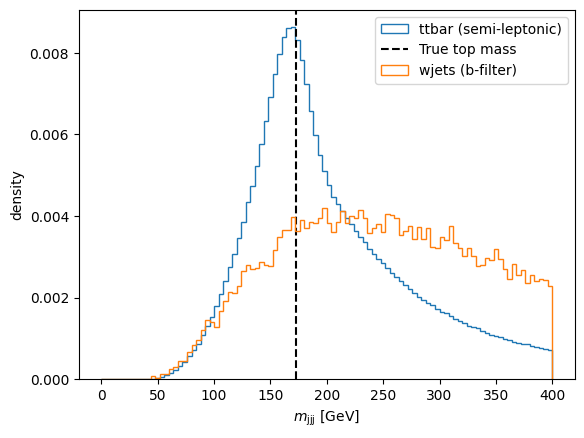

In [148]:
plt.hist(array_ttbar.to_numpy() / GeV, bins=100, range=(0, 400), histtype="step", label="ttbar (semi-leptonic)", density=True);
plt.axvline(172.76, linestyle="--", color="black", label="True top mass")
plt.hist(array_wenu.to_numpy() / GeV, bins=100, range=(0, 400), histtype="step", label="wjets (b-filter)", density=True);
plt.legend()
plt.xlabel(r"$m_\mathrm{jjj}$ [GeV]")
plt.ylabel("density")

This is nice, but there is a lot of complexity involved. Look at [crosscheck_no_dask_awkward.ipynb](crosscheck_no_dask_awkward.ipynb) for an example to do this without `dask_awkward` and `coffea` (only `uproot`, `awkward`, `vector` and plain `dask`)